# Data Visualisation & Analyse Approfondie

---

Ce notebook propose une analyse avancée des données économiques et démographiques avec des visualisations élaborées pour identifier les patterns et insights pertinents pour le projet Compagnon Immobilier.

## 1. Configuration

In [1]:
import subprocess
import sys
subprocess.run([sys.executable, "-m", "pip", "install", "scipy", "scikit-learn", "-q"])

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from datetime import datetime
import warnings

warnings.filterwarnings('ignore')

# Configuration graphique avancée
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_theme(style="whitegrid", palette="husl")

# Paramètres personnalisés
COLORS = {
    'primary': '#2C3E50',
    'secondary': '#E74C3C',
    'accent': '#3498DB',
    'success': '#27AE60',
    'warning': '#F39C12',
    'info': '#9B59B6'
}

plt.rcParams['figure.figsize'] = (14, 7)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 11
plt.rcParams['figure.dpi'] = 100

# Chemins
PROJECT_ROOT = os.path.dirname(os.getcwd())
DATA_DIR = os.path.join(PROJECT_ROOT, 'data')
CLEAN_DIR = os.path.join(DATA_DIR, 'clean')

print(f"Configuration chargée - {datetime.now().strftime('%Y-%m-%d %H:%M')}")

Configuration chargée - 2025-12-26 14:11


In [2]:
# Chargement de toutes les données nettoyées
def load(name):
    return pd.read_csv(os.path.join(CLEAN_DIR, name))

# Données
df_pib = load('pib_clean.csv')
df_ipc = load('ipc_clean.csv')
df_prix = load('prix_logements_clean.csv')
df_chomage_nat = load('chomage_national_clean.csv')
df_chomage_dept = load('chomage_departements_clean.csv')
df_chomage_reg = load('chomage_regions_clean.csv')
df_pop_series = load('population_series_clean.csv')
df_pop_fr = load('population_france_clean.csv')
df_revenus = load('revenus_menages_clean.csv')
df_pauvrete = load('pauvrete_clean.csv')
df_revenus_2021 = load('revenus_communes_2021_clean.csv')
df_pauvrete_2021 = load('pauvrete_communes_2021_clean.csv')
df_construction = load('construction_logements_clean.csv')
df_parc = load('parc_logements_clean.csv')
df_emploi = load('emploi_clean.csv')
df_entreprises = load('entreprises_clean.csv')

print("Toutes les données chargées avec succès")

Toutes les données chargées avec succès


---

## 2. Dashboard Macroéconomique

Vue d'ensemble des indicateurs macroéconomiques clés sur une seule figure.

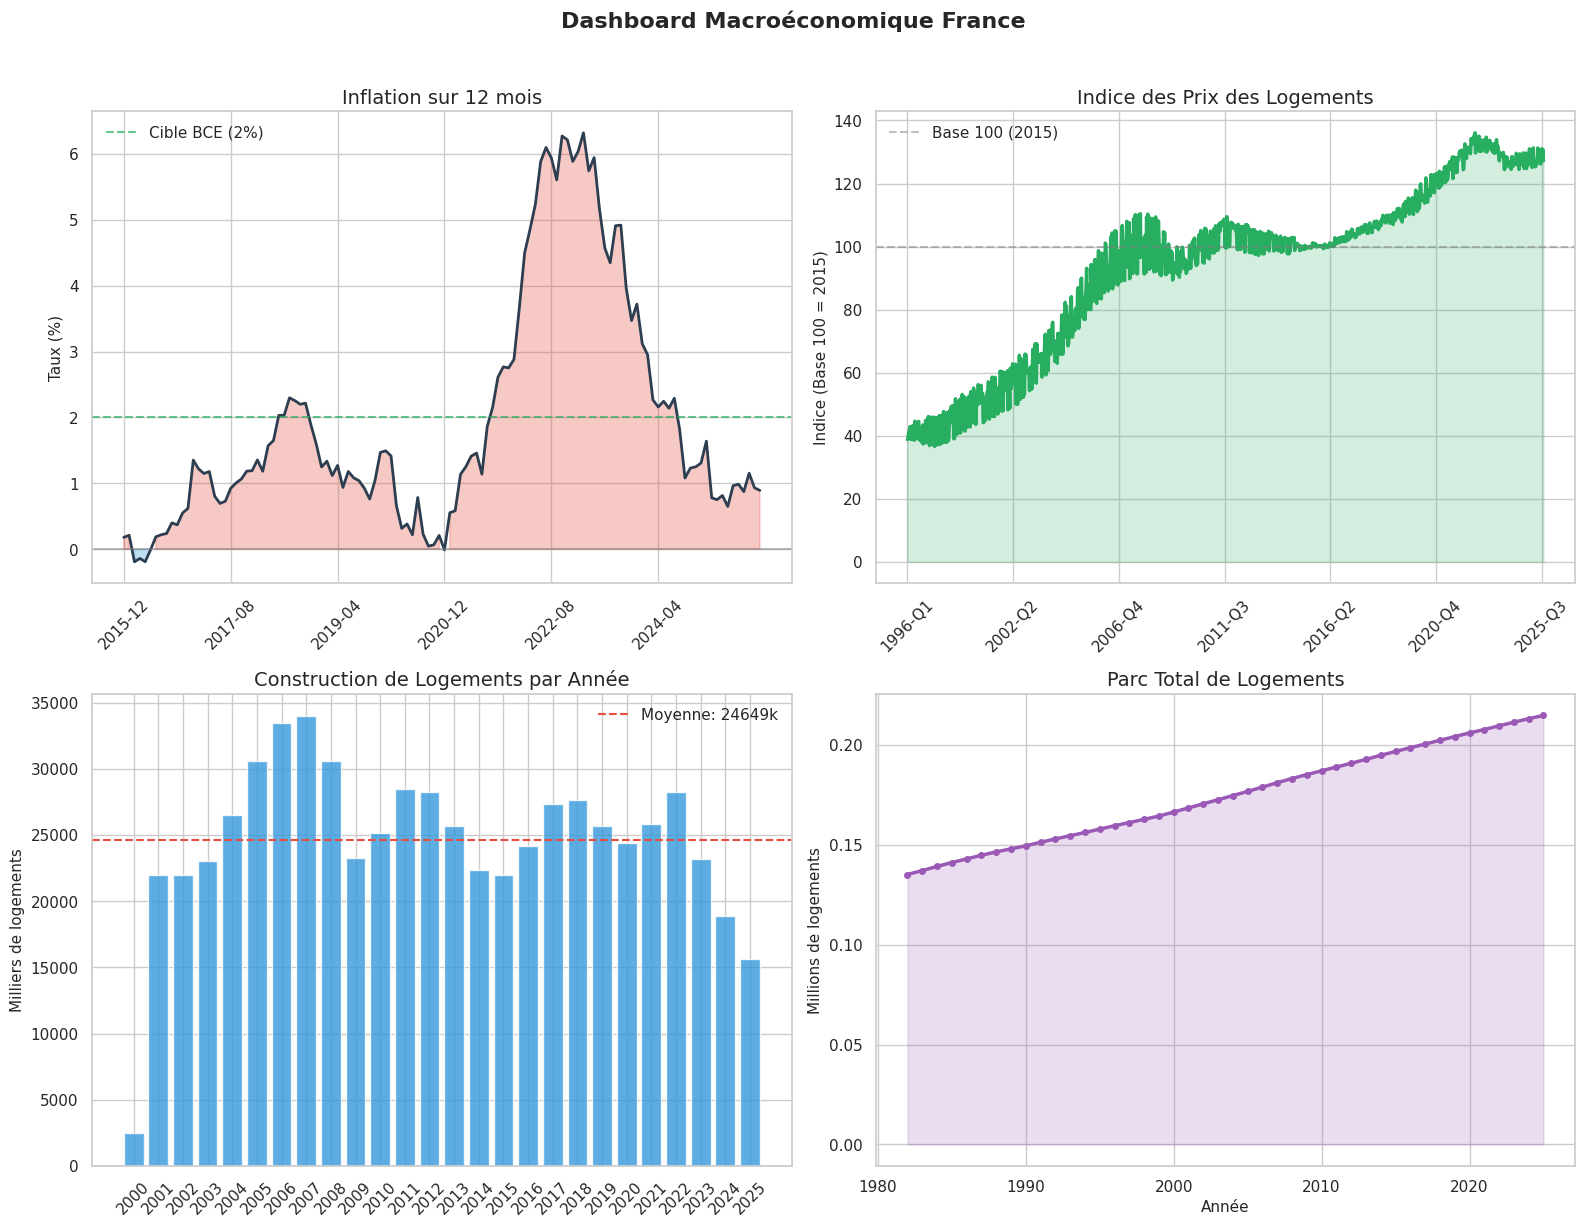

In [3]:
# Dashboard multi-indicateurs
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Dashboard Macroéconomique France', fontsize=16, fontweight='bold', y=1.02)

# 1. Inflation (IPC)
ax1 = axes[0, 0]
df_ipc_plot = df_ipc.dropna(subset=['inflation_12m']).tail(120)  # 10 dernières années
ax1.fill_between(range(len(df_ipc_plot)), df_ipc_plot['inflation_12m'], 
                 where=df_ipc_plot['inflation_12m'] >= 0, color=COLORS['secondary'], alpha=0.3)
ax1.fill_between(range(len(df_ipc_plot)), df_ipc_plot['inflation_12m'], 
                 where=df_ipc_plot['inflation_12m'] < 0, color=COLORS['accent'], alpha=0.3)
ax1.plot(range(len(df_ipc_plot)), df_ipc_plot['inflation_12m'], color=COLORS['primary'], linewidth=2)
ax1.axhline(y=2, color=COLORS['success'], linestyle='--', alpha=0.7, label='Cible BCE (2%)')
ax1.axhline(y=0, color='gray', linestyle='-', alpha=0.5)
ax1.set_title('Inflation sur 12 mois')
ax1.set_ylabel('Taux (%)')
ax1.legend(loc='upper left')
# Étiquettes x
n_ticks = 6
step = len(df_ipc_plot) // n_ticks
ax1.set_xticks(range(0, len(df_ipc_plot), step))
ax1.set_xticklabels(df_ipc_plot['periode'].iloc[::step], rotation=45)

# 2. Prix des logements (France)
ax2 = axes[0, 1]
df_prix_fm = df_prix[df_prix['zone'] == 'FM'].sort_values('periode')
ax2.plot(range(len(df_prix_fm)), df_prix_fm['indice_prix'], color=COLORS['success'], linewidth=2.5)
ax2.fill_between(range(len(df_prix_fm)), df_prix_fm['indice_prix'], alpha=0.2, color=COLORS['success'])
ax2.axhline(y=100, color='gray', linestyle='--', alpha=0.5, label='Base 100 (2015)')
ax2.set_title('Indice des Prix des Logements')
ax2.set_ylabel('Indice (Base 100 = 2015)')
ax2.legend(loc='upper left')
step = len(df_prix_fm) // n_ticks
ax2.set_xticks(range(0, len(df_prix_fm), step))
ax2.set_xticklabels(df_prix_fm['periode'].iloc[::step], rotation=45)

# 3. Construction de logements (tendance annuelle)
ax3 = axes[1, 0]
df_constr_annuel = df_construction.groupby('annee')['nb_logements'].sum().reset_index()
bars = ax3.bar(df_constr_annuel['annee'].astype(str), df_constr_annuel['nb_logements'] / 1000, 
               color=COLORS['accent'], edgecolor='white', alpha=0.8)
ax3.set_title('Construction de Logements par Année')
ax3.set_ylabel('Milliers de logements')
ax3.tick_params(axis='x', rotation=45)
# Moyenne mobile
moyenne = df_constr_annuel['nb_logements'].mean() / 1000
ax3.axhline(y=moyenne, color=COLORS['secondary'], linestyle='--', label=f'Moyenne: {moyenne:.0f}k')
ax3.legend()

# 4. Évolution parc de logements
ax4 = axes[1, 1]
df_parc_agg = df_parc.groupby('annee')['nb_logements'].sum().reset_index()
ax4.plot(df_parc_agg['annee'], df_parc_agg['nb_logements'] / 1e6, 
         color=COLORS['info'], linewidth=2.5, marker='o', markersize=4)
ax4.fill_between(df_parc_agg['annee'], df_parc_agg['nb_logements'] / 1e6, alpha=0.2, color=COLORS['info'])
ax4.set_title('Parc Total de Logements')
ax4.set_ylabel('Millions de logements')
ax4.set_xlabel('Année')

plt.tight_layout()
plt.show()

---

## 3. Analyse Temporelle Croisée

Superposition des indicateurs pour identifier les corrélations temporelles.

In [4]:
# Préparation des données pour analyse croisée (données trimestrielles)
# Prix logements France
df_prix_trim = df_prix[df_prix['zone'] == 'FM'][['periode', 'indice_prix']].copy()
df_prix_trim.columns = ['trimestre', 'prix_logements']

# IPC - agrégation trimestrielle
df_ipc['trimestre'] = df_ipc['periode'].str[:4] + '-Q' + ((df_ipc['mois'] - 1) // 3 + 1).astype(str)
df_ipc_trim = df_ipc.groupby('trimestre').agg({'indice_prix': 'mean', 'inflation_12m': 'mean'}).reset_index()
df_ipc_trim.columns = ['trimestre', 'ipc', 'inflation']

# Fusion
df_croise = df_prix_trim.merge(df_ipc_trim, on='trimestre', how='inner')
df_croise = df_croise.sort_values('trimestre')

print(f"Données croisées : {len(df_croise)} trimestres ({df_croise['trimestre'].min()} → {df_croise['trimestre'].max()})")

Données croisées : 1126 trimestres (1996-Q1 → 2025-Q3)


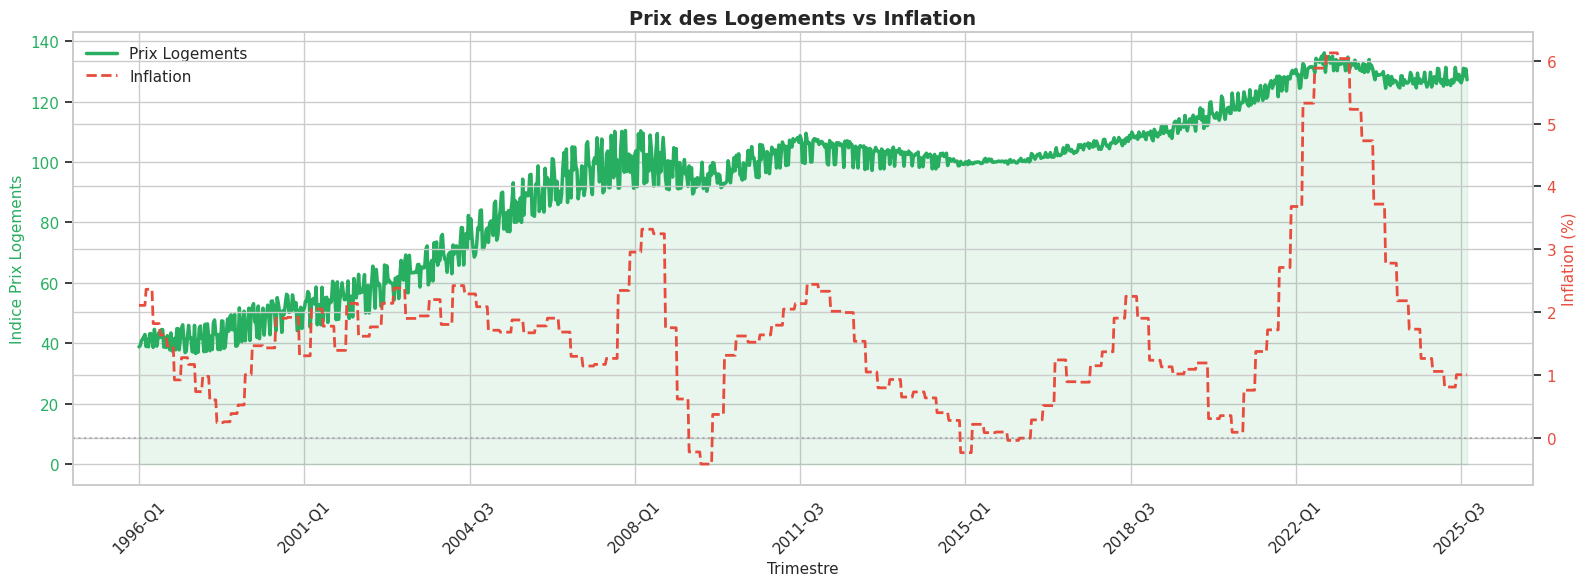


Corrélation Prix Logements ↔ Inflation : 0.241


In [5]:
# Graphique à double axe Y : Prix logements vs Inflation
fig, ax1 = plt.subplots(figsize=(16, 6))

# Axe 1 : Prix des logements
color1 = COLORS['success']
ax1.set_xlabel('Trimestre')
ax1.set_ylabel('Indice Prix Logements', color=color1)
line1, = ax1.plot(range(len(df_croise)), df_croise['prix_logements'], 
                  color=color1, linewidth=2.5, label='Prix Logements')
ax1.tick_params(axis='y', labelcolor=color1)
ax1.fill_between(range(len(df_croise)), df_croise['prix_logements'], alpha=0.1, color=color1)

# Axe 2 : Inflation
ax2 = ax1.twinx()
color2 = COLORS['secondary']
ax2.set_ylabel('Inflation (%)', color=color2)
line2, = ax2.plot(range(len(df_croise)), df_croise['inflation'], 
                  color=color2, linewidth=2, linestyle='--', label='Inflation')
ax2.tick_params(axis='y', labelcolor=color2)
ax2.axhline(y=0, color='gray', linestyle=':', alpha=0.5)

# Légende combinée
lines = [line1, line2]
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper left')

# Étiquettes X
step = len(df_croise) // 8
ax1.set_xticks(range(0, len(df_croise), step))
ax1.set_xticklabels(df_croise['trimestre'].iloc[::step], rotation=45)

plt.title('Prix des Logements vs Inflation', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Corrélation
corr = df_croise['prix_logements'].corr(df_croise['inflation'])
print(f"\nCorrélation Prix Logements ↔ Inflation : {corr:.3f}")

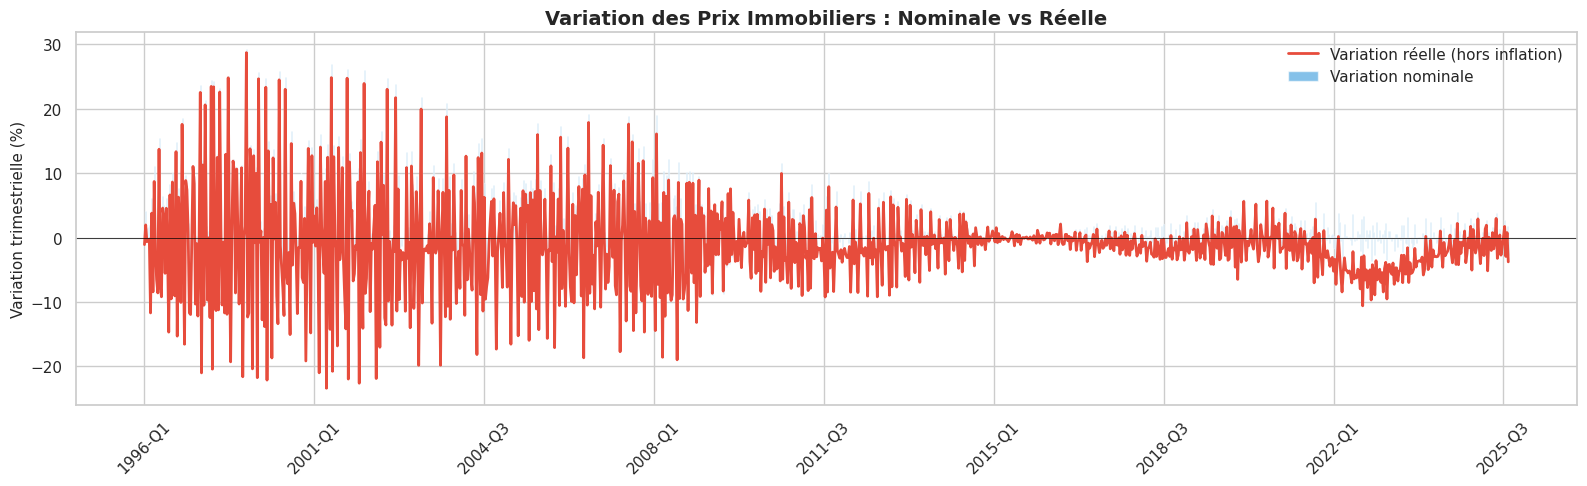

Variation nominale moyenne : 0.33% / trimestre
Variation réelle moyenne : -1.31% / trimestre


In [6]:
# Analyse de la variation des prix par rapport à l'inflation
df_croise['var_prix'] = df_croise['prix_logements'].pct_change() * 100
df_croise['prix_reel'] = df_croise['var_prix'] - df_croise['inflation']  # Variation réelle

fig, ax = plt.subplots(figsize=(16, 5))

# Variation nominale vs réelle
x = range(len(df_croise.dropna()))
df_plot = df_croise.dropna()

ax.bar(x, df_plot['var_prix'], alpha=0.6, color=COLORS['accent'], label='Variation nominale', width=0.8)
ax.plot(x, df_plot['prix_reel'], color=COLORS['secondary'], linewidth=2, label='Variation réelle (hors inflation)')
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)

ax.set_title('Variation des Prix Immobiliers : Nominale vs Réelle', fontsize=14, fontweight='bold')
ax.set_ylabel('Variation trimestrielle (%)')
ax.legend()

step = len(df_plot) // 8
ax.set_xticks(range(0, len(df_plot), step))
ax.set_xticklabels(df_plot['trimestre'].iloc[::step], rotation=45)

plt.tight_layout()
plt.show()

print(f"Variation nominale moyenne : {df_plot['var_prix'].mean():.2f}% / trimestre")
print(f"Variation réelle moyenne : {df_plot['prix_reel'].mean():.2f}% / trimestre")

---

## 4. Analyse Géographique par Département

In [7]:
# Création d'un DataFrame consolidé par département
# Revenus 2021
rev_dept = df_revenus_2021.groupby('code_dept').agg({
    'revenu_median': 'median',
    'nb_menages': 'sum',
    'nb_personnes': 'sum'
}).reset_index()

# Chômage (dernière période)
derniere_periode = df_chomage_dept['periode'].max()
chomage_dept = df_chomage_dept[df_chomage_dept['periode'] == derniere_periode][['zone', 'taux_chomage']].copy()
chomage_dept['code_dept'] = chomage_dept['zone'].str.replace('D', '')

# Pauvreté (dernière année)
derniere_annee = df_pauvrete['annee'].max()
pauv_dept = df_pauvrete[df_pauvrete['annee'] == derniere_annee].groupby('zone')['taux_pauvrete'].mean().reset_index()
pauv_dept['code_dept'] = pauv_dept['zone'].str.replace('D', '')

# Emploi (nombre d'établissements)
emploi_dept = df_emploi.groupby('code_dept')['nb_etablissements'].sum().reset_index()

# Entreprises (créations)
entrep_dept = df_entreprises.groupby('code_dept')['nb_creations'].sum().reset_index()

# Fusion progressive
df_dept = rev_dept.copy()
df_dept = df_dept.merge(chomage_dept[['code_dept', 'taux_chomage']], on='code_dept', how='left')
df_dept = df_dept.merge(pauv_dept[['code_dept', 'taux_pauvrete']], on='code_dept', how='left')
df_dept = df_dept.merge(emploi_dept, on='code_dept', how='left')
df_dept = df_dept.merge(entrep_dept, on='code_dept', how='left')

# Calcul de la densité d'établissements (pour 1000 habitants)
df_dept['densite_etablissements'] = df_dept['nb_etablissements'] / df_dept['nb_personnes'] * 1000
df_dept['dynamisme_entreprises'] = df_dept['nb_creations'] / df_dept['nb_personnes'] * 1000

# Nettoyage
df_dept = df_dept.dropna(subset=['taux_chomage', 'revenu_median'])

print(f"Données consolidées : {len(df_dept)} départements")
df_dept.head()

Données consolidées : 96 départements


,code_dept,revenu_median,nb_menages,nb_personnes,taux_chomage,taux_pauvrete,nb_etablissements,nb_creations,densite_etablissements,dynamisme_entreprises
0,01,24560.0,269760.0,631161.0,5.7,10.885714,1229580.0,206102.0,1948.124171,326.544257
1,02,22240.0,221019.0,498709.0,10.3,19.171429,964938.0,117592.0,1934.871839,235.792817
2,03,21415.0,159799.0,323062.0,8.0,16.485714,666222.0,94155.0,2062.210969,291.445605
3,04,21210.0,71574.0,144637.0,8.0,17.528571,325878.0,77192.0,2253.074939,533.694698
4,05,21670.0,64915.0,131515.0,6.5,14.685714,334771.0,76224.0,2545.496711,579.584078


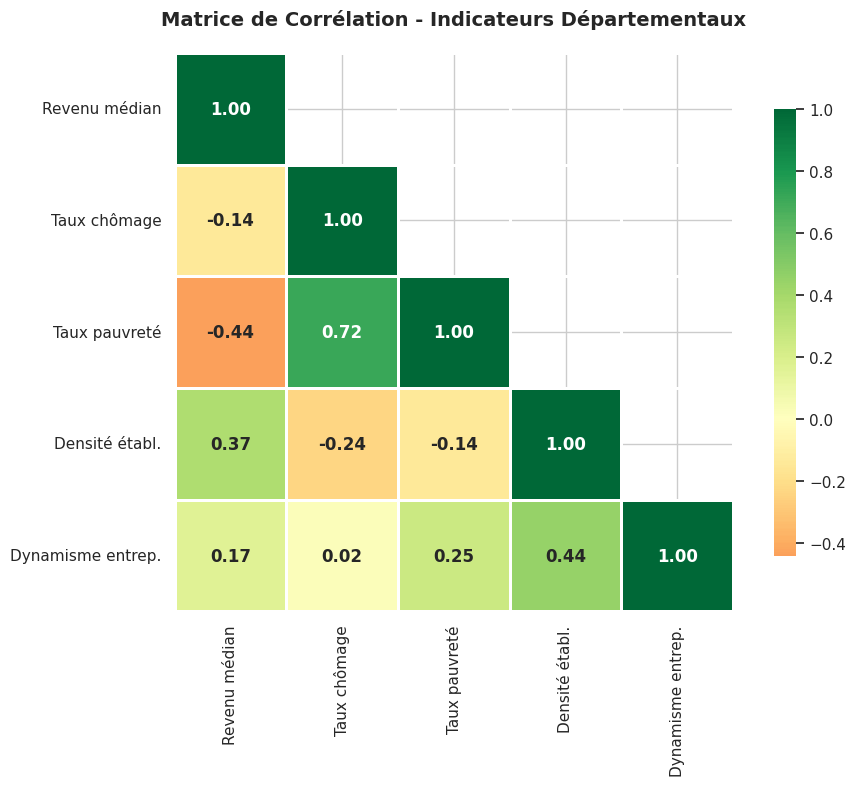

In [8]:
# Heatmap de corrélation
cols_corr = ['revenu_median', 'taux_chomage', 'taux_pauvrete', 'densite_etablissements', 'dynamisme_entreprises']
df_corr_matrix = df_dept[cols_corr].dropna()

fig, ax = plt.subplots(figsize=(10, 8))

corr_matrix = df_corr_matrix.corr()

# Labels plus lisibles
labels = ['Revenu médian', 'Taux chômage', 'Taux pauvreté', 'Densité établ.', 'Dynamisme entrep.']

mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap='RdYlGn', center=0,
            square=True, linewidths=2, cbar_kws={'shrink': 0.8},
            xticklabels=labels, yticklabels=labels, ax=ax,
            annot_kws={'size': 12, 'weight': 'bold'})

ax.set_title('Matrice de Corrélation - Indicateurs Départementaux', fontsize=14, fontweight='bold', pad=20)

plt.tight_layout()
plt.show()

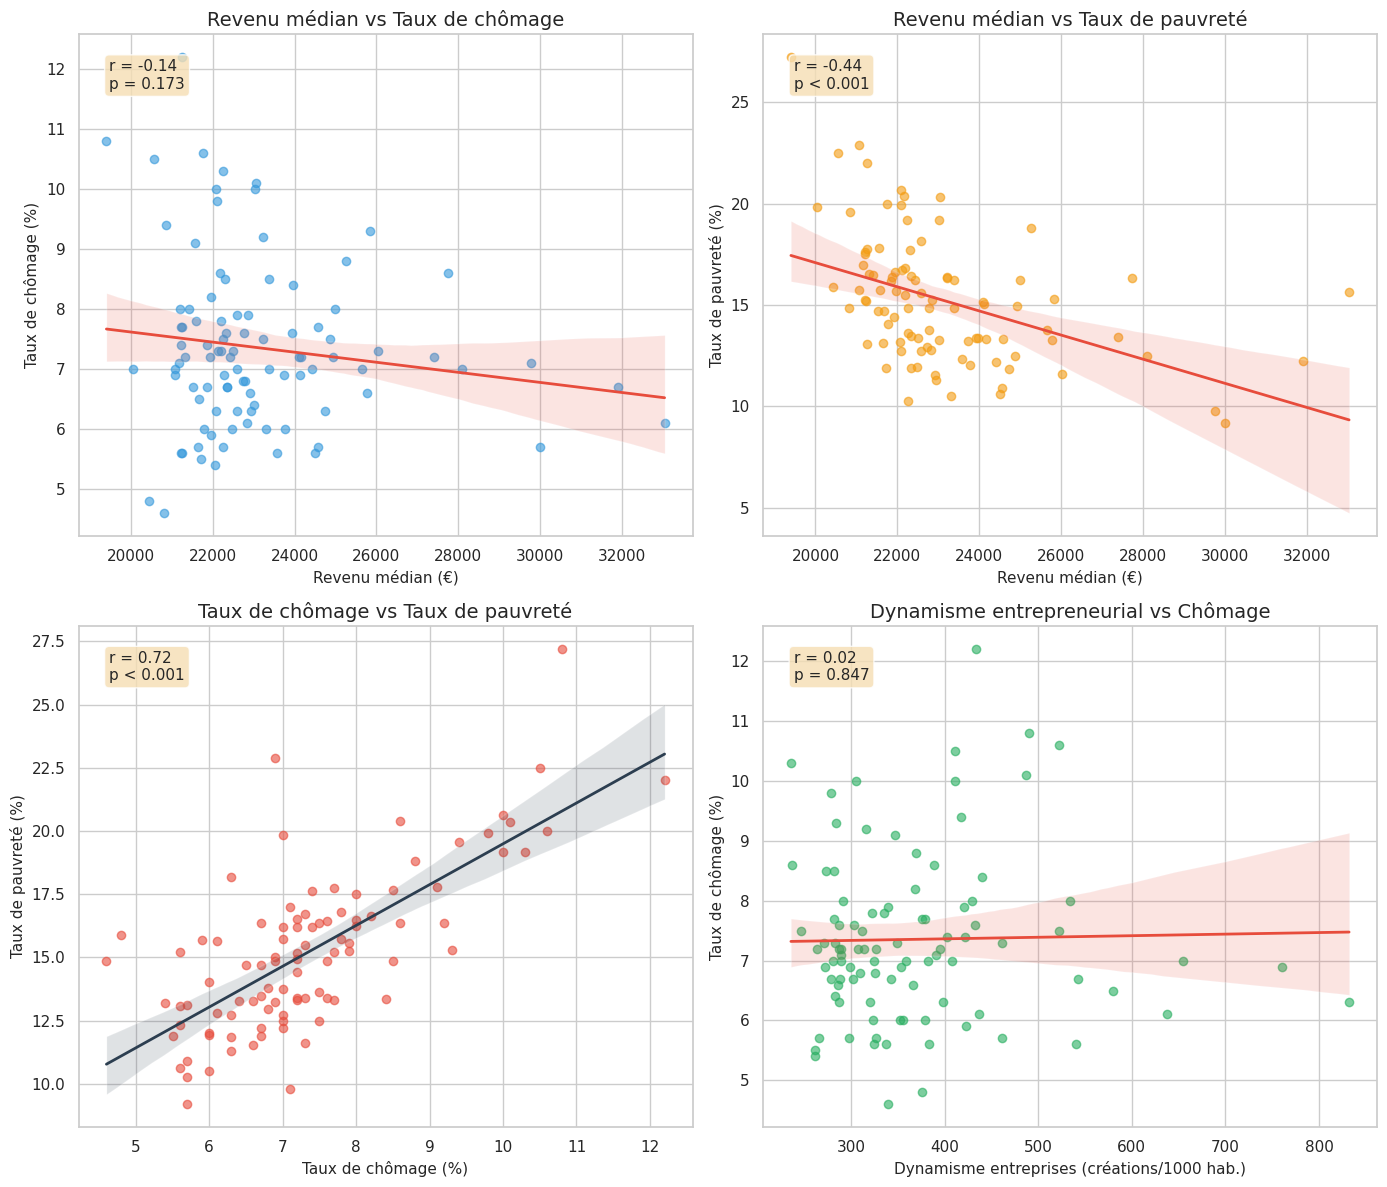

In [9]:
# Scatter plots avec régression
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# 1. Revenu vs Chômage
ax1 = axes[0, 0]
sns.regplot(x='revenu_median', y='taux_chomage', data=df_dept, ax=ax1,
            scatter_kws={'alpha': 0.6, 'color': COLORS['accent']},
            line_kws={'color': COLORS['secondary'], 'linewidth': 2})
ax1.set_xlabel('Revenu médian (€)')
ax1.set_ylabel('Taux de chômage (%)')
ax1.set_title('Revenu médian vs Taux de chômage')
r, p = stats.pearsonr(df_dept['revenu_median'].dropna(), df_dept['taux_chomage'].dropna())
ax1.text(0.05, 0.95, f'r = {r:.2f}\np < 0.001' if p < 0.001 else f'r = {r:.2f}\np = {p:.3f}', 
         transform=ax1.transAxes, va='top', fontsize=11, 
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

# 2. Revenu vs Pauvreté
ax2 = axes[0, 1]
df_plot2 = df_dept.dropna(subset=['revenu_median', 'taux_pauvrete'])
sns.regplot(x='revenu_median', y='taux_pauvrete', data=df_plot2, ax=ax2,
            scatter_kws={'alpha': 0.6, 'color': COLORS['warning']},
            line_kws={'color': COLORS['secondary'], 'linewidth': 2})
ax2.set_xlabel('Revenu médian (€)')
ax2.set_ylabel('Taux de pauvreté (%)')
ax2.set_title('Revenu médian vs Taux de pauvreté')
r, p = stats.pearsonr(df_plot2['revenu_median'], df_plot2['taux_pauvrete'])
ax2.text(0.05, 0.95, f'r = {r:.2f}\np < 0.001' if p < 0.001 else f'r = {r:.2f}\np = {p:.3f}', 
         transform=ax2.transAxes, va='top', fontsize=11,
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

# 3. Chômage vs Pauvreté
ax3 = axes[1, 0]
df_plot3 = df_dept.dropna(subset=['taux_chomage', 'taux_pauvrete'])
sns.regplot(x='taux_chomage', y='taux_pauvrete', data=df_plot3, ax=ax3,
            scatter_kws={'alpha': 0.6, 'color': COLORS['secondary']},
            line_kws={'color': COLORS['primary'], 'linewidth': 2})
ax3.set_xlabel('Taux de chômage (%)')
ax3.set_ylabel('Taux de pauvreté (%)')
ax3.set_title('Taux de chômage vs Taux de pauvreté')
r, p = stats.pearsonr(df_plot3['taux_chomage'], df_plot3['taux_pauvrete'])
ax3.text(0.05, 0.95, f'r = {r:.2f}\np < 0.001' if p < 0.001 else f'r = {r:.2f}\np = {p:.3f}', 
         transform=ax3.transAxes, va='top', fontsize=11,
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

# 4. Dynamisme vs Chômage
ax4 = axes[1, 1]
df_plot4 = df_dept.dropna(subset=['dynamisme_entreprises', 'taux_chomage'])
sns.regplot(x='dynamisme_entreprises', y='taux_chomage', data=df_plot4, ax=ax4,
            scatter_kws={'alpha': 0.6, 'color': COLORS['success']},
            line_kws={'color': COLORS['secondary'], 'linewidth': 2})
ax4.set_xlabel('Dynamisme entreprises (créations/1000 hab.)')
ax4.set_ylabel('Taux de chômage (%)')
ax4.set_title('Dynamisme entrepreneurial vs Chômage')
r, p = stats.pearsonr(df_plot4['dynamisme_entreprises'], df_plot4['taux_chomage'])
ax4.text(0.05, 0.95, f'r = {r:.2f}\np < 0.001' if p < 0.001 else f'r = {r:.2f}\np = {p:.3f}', 
         transform=ax4.transAxes, va='top', fontsize=11,
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.tight_layout()
plt.show()

---

## 5. Segmentation des Départements

Classification des départements selon leur profil socio-économique.

In [10]:
# Création d'un score composite pour classer les départements
from sklearn.preprocessing import StandardScaler

# Variables pour le scoring
cols_score = ['revenu_median', 'taux_chomage', 'taux_pauvrete']
df_score = df_dept.dropna(subset=cols_score).copy()

# Normalisation
scaler = StandardScaler()
df_score[['rev_norm', 'chom_norm', 'pauv_norm']] = scaler.fit_transform(df_score[cols_score])

# Score d'attractivité : + revenu, - chômage, - pauvreté
df_score['score_attractivite'] = df_score['rev_norm'] - df_score['chom_norm'] - df_score['pauv_norm']

# Catégorisation en quartiles
df_score['categorie'] = pd.qcut(df_score['score_attractivite'], q=4, 
                                 labels=['Défavorisé', 'Modeste', 'Intermédiaire', 'Favorable'])

print(f"Distribution des départements par catégorie :")
print(df_score['categorie'].value_counts().sort_index())

Distribution des départements par catégorie :
categorie
Défavorisé       24
Modeste          24
Intermédiaire    24
Favorable        24
Name: count, dtype: int64


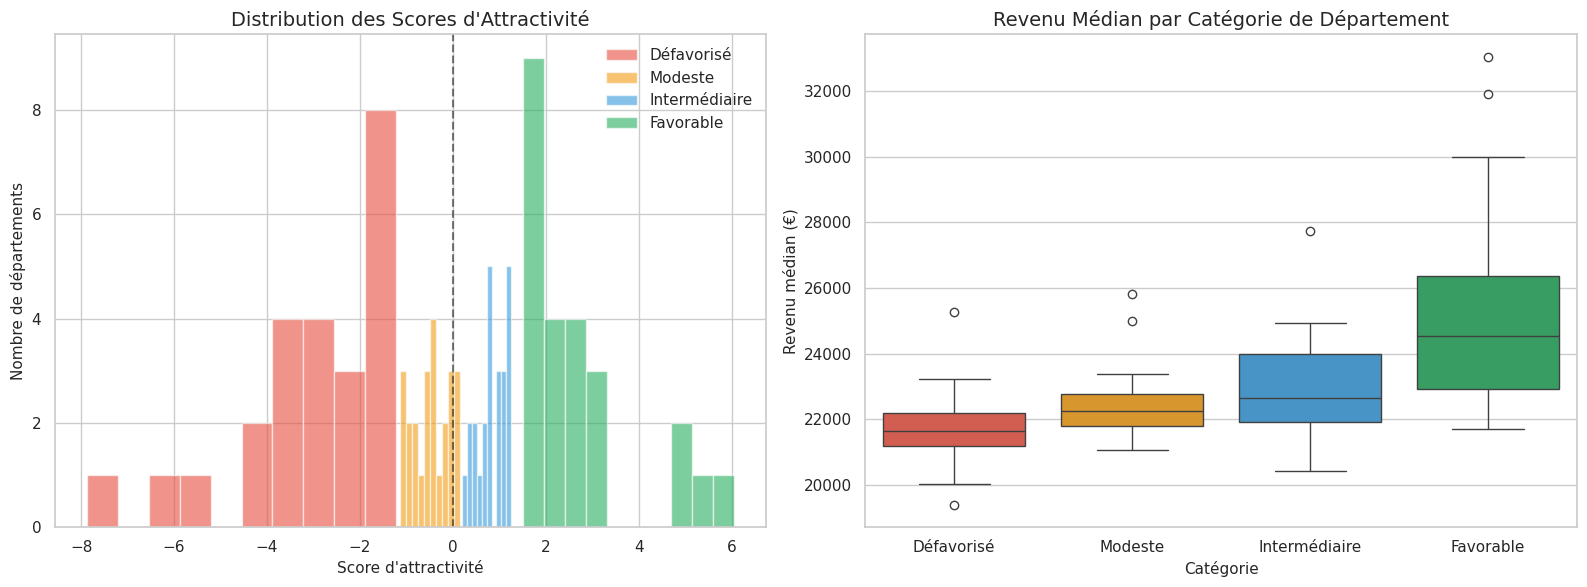

In [11]:
# Visualisation des catégories
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. Distribution du score
ax1 = axes[0]
colors_cat = {'Défavorisé': COLORS['secondary'], 'Modeste': COLORS['warning'], 
              'Intermédiaire': COLORS['accent'], 'Favorable': COLORS['success']}

for cat in ['Défavorisé', 'Modeste', 'Intermédiaire', 'Favorable']:
    data = df_score[df_score['categorie'] == cat]['score_attractivite']
    ax1.hist(data, bins=10, alpha=0.6, label=cat, color=colors_cat[cat])

ax1.set_xlabel('Score d\'attractivité')
ax1.set_ylabel('Nombre de départements')
ax1.set_title('Distribution des Scores d\'Attractivité')
ax1.legend()
ax1.axvline(x=0, color='black', linestyle='--', alpha=0.5)

# 2. Box plot par catégorie
ax2 = axes[1]
df_melt = df_score.melt(id_vars=['code_dept', 'categorie'], 
                         value_vars=['revenu_median'], 
                         var_name='indicateur', value_name='valeur')

order = ['Défavorisé', 'Modeste', 'Intermédiaire', 'Favorable']
palette = [colors_cat[c] for c in order]
sns.boxplot(x='categorie', y='valeur', data=df_melt, order=order, palette=palette, ax=ax2)
ax2.set_xlabel('Catégorie')
ax2.set_ylabel('Revenu médian (€)')
ax2.set_title('Revenu Médian par Catégorie de Département')

plt.tight_layout()
plt.show()

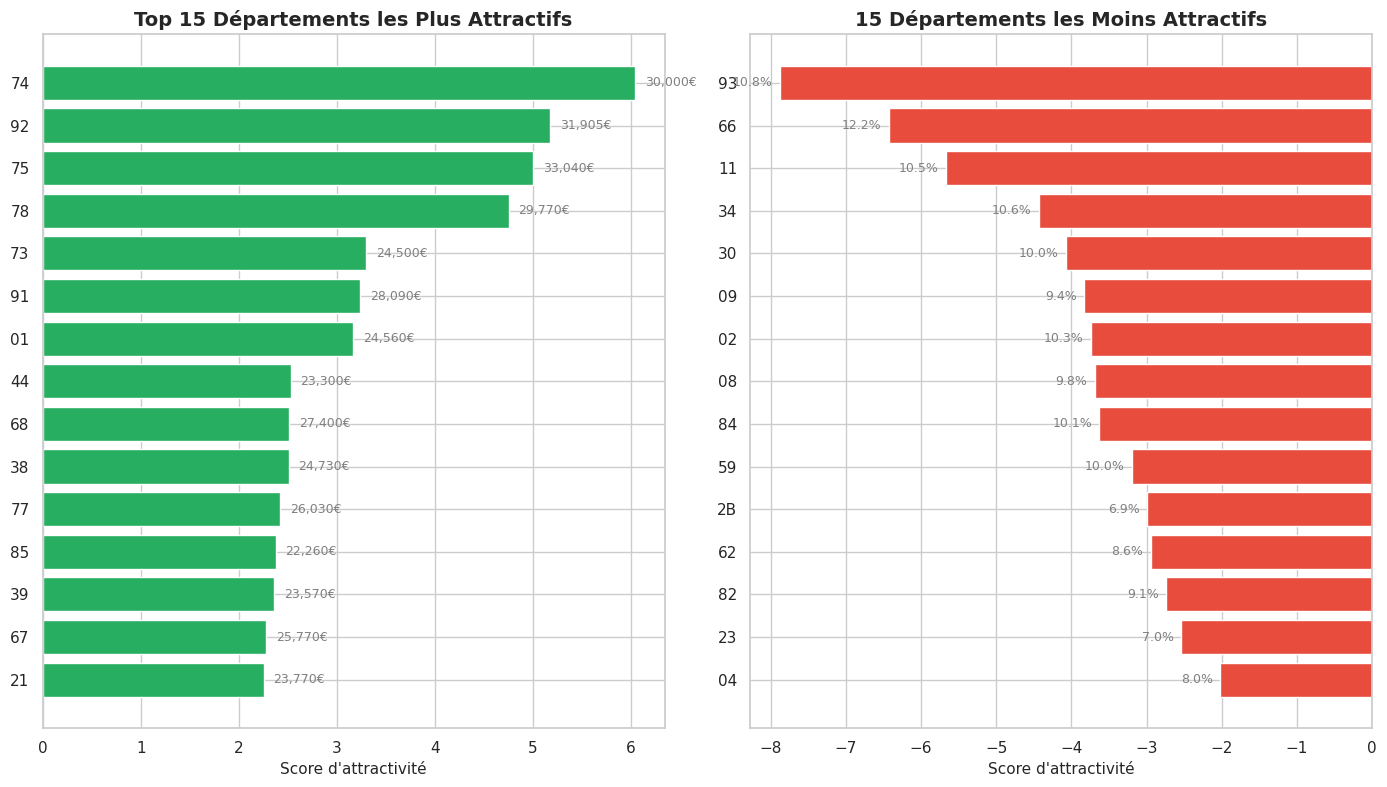

In [12]:
# Top et Flop départements
df_sorted = df_score.sort_values('score_attractivite', ascending=False)

fig, axes = plt.subplots(1, 2, figsize=(14, 8))

# Top 15
ax1 = axes[0]
top15 = df_sorted.head(15)
colors_top = [COLORS['success']] * 15
ax1.barh(range(15), top15['score_attractivite'], color=colors_top, edgecolor='white')
ax1.set_yticks(range(15))
ax1.set_yticklabels(top15['code_dept'])
ax1.invert_yaxis()
ax1.set_xlabel('Score d\'attractivité')
ax1.set_title('Top 15 Départements les Plus Attractifs', fontweight='bold')

# Annotations revenu
for i, (idx, row) in enumerate(top15.iterrows()):
    ax1.text(row['score_attractivite'] + 0.1, i, f"{row['revenu_median']:,.0f}€", 
             va='center', fontsize=9, color='gray')

# Flop 15
ax2 = axes[1]
flop15 = df_sorted.tail(15).iloc[::-1]
colors_flop = [COLORS['secondary']] * 15
ax2.barh(range(15), flop15['score_attractivite'], color=colors_flop, edgecolor='white')
ax2.set_yticks(range(15))
ax2.set_yticklabels(flop15['code_dept'])
ax2.invert_yaxis()
ax2.set_xlabel('Score d\'attractivité')
ax2.set_title('15 Départements les Moins Attractifs', fontweight='bold')

# Annotations chômage
for i, (idx, row) in enumerate(flop15.iterrows()):
    ax2.text(row['score_attractivite'] - 0.1, i, f"{row['taux_chomage']:.1f}%", 
             va='center', ha='right', fontsize=9, color='gray')

plt.tight_layout()
plt.show()

---

## 6. Analyse des Distributions

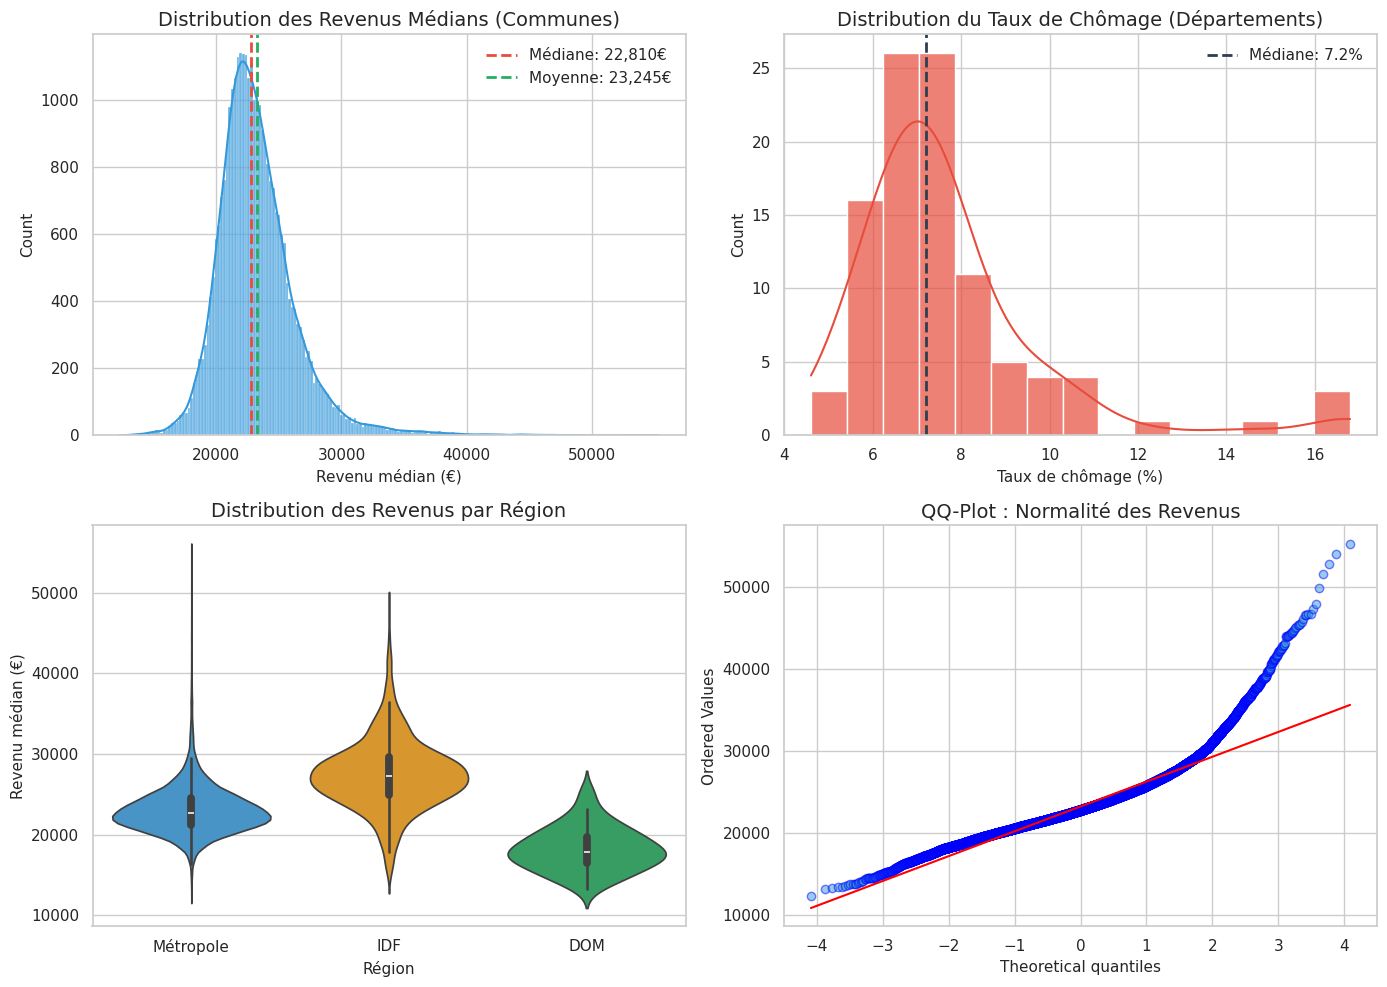


Test de Shapiro-Wilk (normalité des revenus) : p-value = 0.0000
→ Distribution non-normale


In [13]:
# Distribution des revenus par commune avec KDE
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Revenus médians (communes)
ax1 = axes[0, 0]
sns.histplot(df_revenus_2021['revenu_median'], kde=True, color=COLORS['accent'], 
             edgecolor='white', alpha=0.7, ax=ax1)
ax1.axvline(df_revenus_2021['revenu_median'].median(), color=COLORS['secondary'], 
            linestyle='--', linewidth=2, label=f"Médiane: {df_revenus_2021['revenu_median'].median():,.0f}€")
ax1.axvline(df_revenus_2021['revenu_median'].mean(), color=COLORS['success'], 
            linestyle='--', linewidth=2, label=f"Moyenne: {df_revenus_2021['revenu_median'].mean():,.0f}€")
ax1.set_title('Distribution des Revenus Médians (Communes)')
ax1.set_xlabel('Revenu médian (€)')
ax1.legend()

# 2. Taux de chômage (départements)
ax2 = axes[0, 1]
chomage_recent = df_chomage_dept[df_chomage_dept['periode'] == df_chomage_dept['periode'].max()]
sns.histplot(chomage_recent['taux_chomage'], kde=True, color=COLORS['secondary'], 
             edgecolor='white', alpha=0.7, ax=ax2, bins=15)
ax2.axvline(chomage_recent['taux_chomage'].median(), color=COLORS['primary'], 
            linestyle='--', linewidth=2, label=f"Médiane: {chomage_recent['taux_chomage'].median():.1f}%")
ax2.set_title('Distribution du Taux de Chômage (Départements)')
ax2.set_xlabel('Taux de chômage (%)')
ax2.legend()

# 3. Violin plot : Revenus par région (via code_dept)
ax3 = axes[1, 0]
# Regrouper les départements par grande région (simplification)
df_revenus_2021['region'] = df_revenus_2021['code_dept'].apply(
    lambda x: 'IDF' if x in ['75', '77', '78', '91', '92', '93', '94', '95'] 
    else ('DOM' if x in ['97', '98'] or (x.startswith('97')) else 'Métropole'))

sns.violinplot(x='region', y='revenu_median', data=df_revenus_2021, 
               palette=[COLORS['accent'], COLORS['warning'], COLORS['success']], ax=ax3)
ax3.set_title('Distribution des Revenus par Région')
ax3.set_xlabel('Région')
ax3.set_ylabel('Revenu médian (€)')

# 4. QQ-Plot pour tester la normalité des revenus
ax4 = axes[1, 1]
stats.probplot(df_revenus_2021['revenu_median'].dropna(), dist="norm", plot=ax4)
ax4.set_title('QQ-Plot : Normalité des Revenus')
ax4.get_lines()[0].set_markerfacecolor(COLORS['accent'])
ax4.get_lines()[0].set_alpha(0.5)

plt.tight_layout()
plt.show()

# Test de normalité
stat, p_value = stats.shapiro(df_revenus_2021['revenu_median'].dropna().sample(min(5000, len(df_revenus_2021))))
print(f"\nTest de Shapiro-Wilk (normalité des revenus) : p-value = {p_value:.4f}")
print("→ Distribution non-normale" if p_value < 0.05 else "→ Distribution normale")

---

## 7. Évolution Temporelle Multi-Indicateurs

In [14]:
# Évolution annuelle normalisée de plusieurs indicateurs
# Préparation des données annuelles

# Prix logements (moyenne annuelle)
df_prix_an = df_prix[df_prix['zone'] == 'FM'].groupby('annee')['indice_prix'].mean().reset_index()
df_prix_an.columns = ['annee', 'prix_logements']

# IPC (moyenne annuelle)
df_ipc_an = df_ipc.groupby('annee')['indice_prix'].mean().reset_index()
df_ipc_an.columns = ['annee', 'ipc']

# Construction (total annuel)
df_constr_an = df_construction.groupby('annee')['nb_logements'].sum().reset_index()
df_constr_an.columns = ['annee', 'construction']

# Fusion
df_evol = df_prix_an.merge(df_ipc_an, on='annee', how='inner')
df_evol = df_evol.merge(df_constr_an, on='annee', how='inner')

# Normalisation base 100 première année
for col in ['prix_logements', 'ipc', 'construction']:
    df_evol[f'{col}_norm'] = df_evol[col] / df_evol[col].iloc[0] * 100

print(f"Période d'analyse : {df_evol['annee'].min()} - {df_evol['annee'].max()}")

Période d'analyse : 2000 - 2025


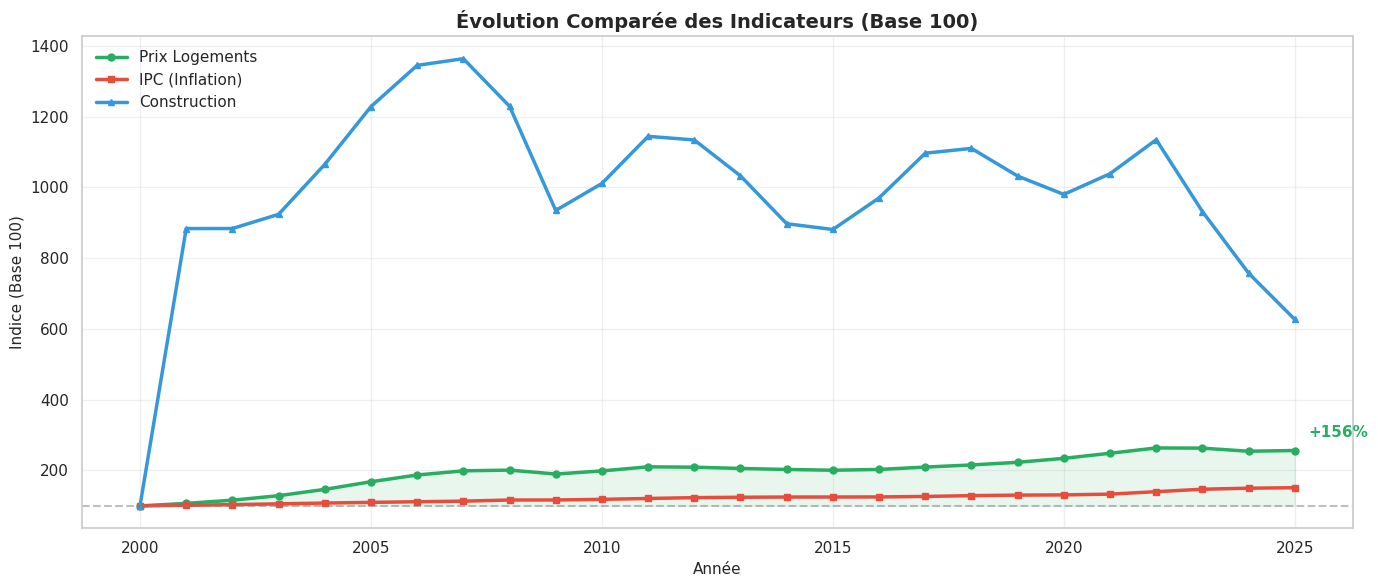


Évolution sur la période :
  Prix logements : +156.5%
  IPC : +51.4%
  Construction : +526.6%


In [15]:
# Graphique multi-indicateurs normalisés
fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(df_evol['annee'], df_evol['prix_logements_norm'], 
        color=COLORS['success'], linewidth=2.5, marker='o', markersize=5, label='Prix Logements')
ax.plot(df_evol['annee'], df_evol['ipc_norm'], 
        color=COLORS['secondary'], linewidth=2.5, marker='s', markersize=5, label='IPC (Inflation)')
ax.plot(df_evol['annee'], df_evol['construction_norm'], 
        color=COLORS['accent'], linewidth=2.5, marker='^', markersize=5, label='Construction')

ax.axhline(y=100, color='gray', linestyle='--', alpha=0.5)
ax.fill_between(df_evol['annee'], 100, df_evol['prix_logements_norm'], 
                alpha=0.1, color=COLORS['success'])

ax.set_title('Évolution Comparée des Indicateurs (Base 100)', fontsize=14, fontweight='bold')
ax.set_xlabel('Année')
ax.set_ylabel('Indice (Base 100)')
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3)

# Annotation de l'écart
derniere = df_evol.iloc[-1]
ax.annotate(f"+{derniere['prix_logements_norm'] - 100:.0f}%", 
            xy=(derniere['annee'], derniere['prix_logements_norm']),
            xytext=(10, 10), textcoords='offset points',
            fontsize=11, color=COLORS['success'], fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\nÉvolution sur la période :")
print(f"  Prix logements : +{derniere['prix_logements_norm'] - 100:.1f}%")
print(f"  IPC : +{derniere['ipc_norm'] - 100:.1f}%")
print(f"  Construction : {derniere['construction_norm'] - 100:+.1f}%")

---

## 8. Indicateurs Clés et Statistiques Descriptives

In [16]:
# Tableau de synthèse des indicateurs
print("=" * 70)
print("TABLEAU DE BORD - INDICATEURS ÉCONOMIQUES ET DÉMOGRAPHIQUES")
print("=" * 70)

# Inflation
print("\n📈 INFLATION")
print(f"   Dernière valeur : {df_ipc['inflation_12m'].iloc[-1]:.1f}% ({df_ipc['periode'].iloc[-1]})")
print(f"   Pic récent : {df_ipc['inflation_12m'].max():.1f}% ({df_ipc.loc[df_ipc['inflation_12m'].idxmax(), 'periode']})")
print(f"   Moyenne 5 ans : {df_ipc.tail(60)['inflation_12m'].mean():.1f}%")

# Prix logements
print("\n🏠 PRIX DES LOGEMENTS")
df_px = df_prix[df_prix['zone'] == 'FM']
print(f"   Indice actuel : {df_px['indice_prix'].iloc[-1]:.1f} (Base 100 = 2015)")
print(f"   Évolution depuis 2000 : +{((df_px['indice_prix'].iloc[-1] / df_px['indice_prix'].iloc[0]) - 1) * 100:.0f}%")

# Chômage
print("\n👥 CHÔMAGE")
chomage_last = df_chomage_dept[df_chomage_dept['periode'] == df_chomage_dept['periode'].max()]
print(f"   Moyenne nationale : {chomage_last['taux_chomage'].mean():.1f}%")
print(f"   Min : {chomage_last['taux_chomage'].min():.1f}% ({chomage_last.loc[chomage_last['taux_chomage'].idxmin(), 'zone']})")
print(f"   Max : {chomage_last['taux_chomage'].max():.1f}% ({chomage_last.loc[chomage_last['taux_chomage'].idxmax(), 'zone']})")

# Revenus
print("\n💰 REVENUS (2021)")
print(f"   Revenu médian moyen : {df_revenus_2021['revenu_median'].mean():,.0f} €")
print(f"   Écart-type : {df_revenus_2021['revenu_median'].std():,.0f} €")
print(f"   Min : {df_revenus_2021['revenu_median'].min():,.0f} € | Max : {df_revenus_2021['revenu_median'].max():,.0f} €")

# Construction
print("\n🏗️ CONSTRUCTION")
constr_recent = df_construction[df_construction['annee'] == df_construction['annee'].max()]
print(f"   Logements construits (dernier année complète) : {constr_recent['nb_logements'].sum():,}")
print(f"   Moyenne annuelle : {df_construction.groupby('annee')['nb_logements'].sum().mean():,.0f}")

print("\n" + "=" * 70)

TABLEAU DE BORD - INDICATEURS ÉCONOMIQUES ET DÉMOGRAPHIQUES

📈 INFLATION
   Dernière valeur : 0.9% (2025-11)
   Pic récent : 6.3% (2023-02)
   Moyenne 5 ans : 2.9%

🏠 PRIX DES LOGEMENTS
   Indice actuel : 127.2 (Base 100 = 2015)
   Évolution depuis 2000 : +167%

👥 CHÔMAGE
   Moyenne nationale : 7.7%
   Min : 4.6% (D15)
   Max : 16.8% (D973)

💰 REVENUS (2021)
   Revenu médian moyen : 23,245 €
   Écart-type : 3,174 €
   Min : 12,260 € | Max : 55,340 €

🏗️ CONSTRUCTION
   Logements construits (dernier année complète) : 15,608,384
   Moyenne annuelle : 24,649,066



In [17]:
# Statistiques descriptives détaillées
print("\n📊 STATISTIQUES DESCRIPTIVES - REVENUS PAR COMMUNE (2021)\n")
print(df_revenus_2021['revenu_median'].describe().to_string())

print("\n\n📊 STATISTIQUES DESCRIPTIVES - CHÔMAGE PAR DÉPARTEMENT\n")
print(chomage_last['taux_chomage'].describe().to_string())


📊 STATISTIQUES DESCRIPTIVES - REVENUS PAR COMMUNE (2021)

count    31325.000000
mean     23244.662729
std       3173.820713
min      12260.000000
25%      21270.000000
50%      22810.000000
75%      24710.000000
max      55340.000000


📊 STATISTIQUES DESCRIPTIVES - CHÔMAGE PAR DÉPARTEMENT

count    100.000000
mean       7.705000
std        2.223264
min        4.600000
25%        6.575000
50%        7.200000
75%        8.000000
max       16.800000


---

## 9. Insights pour le Projet Immobilier

In [18]:
# Création d'un score d'opportunité immobilière
# Hypothèse : zones avec revenus élevés, chômage bas, dynamisme entrepreneurial fort = opportunités

df_opportunite = df_score.copy()

# Ajout du dynamisme si disponible
if 'dynamisme_entreprises' in df_dept.columns:
    df_opportunite = df_opportunite.merge(
        df_dept[['code_dept', 'dynamisme_entreprises']], 
        on='code_dept', 
        how='left'
    )

# Top 10 opportunités
top_opportunites = df_opportunite.nlargest(10, 'score_attractivite')[[
    'code_dept', 'revenu_median', 'taux_chomage', 'taux_pauvrete', 'score_attractivite'
]]

print("🎯 TOP 10 DÉPARTEMENTS - OPPORTUNITÉS IMMOBILIÈRES\n")
print("(Score basé sur : revenus élevés, faible chômage, faible pauvreté)\n")

for i, row in top_opportunites.iterrows():
    print(f"  {row['code_dept']:>3} | Revenu: {row['revenu_median']:>7,.0f}€ | "
          f"Chômage: {row['taux_chomage']:>4.1f}% | Pauvreté: {row['taux_pauvrete']:>4.1f}% | "
          f"Score: {row['score_attractivite']:>+5.2f}")

🎯 TOP 10 DÉPARTEMENTS - OPPORTUNITÉS IMMOBILIÈRES

(Score basé sur : revenus élevés, faible chômage, faible pauvreté)

   74 | Revenu:  30,000€ | Chômage:  5.7% | Pauvreté:  9.2% | Score: +6.04
   92 | Revenu:  31,905€ | Chômage:  6.7% | Pauvreté: 12.2% | Score: +5.18
   75 | Revenu:  33,040€ | Chômage:  6.1% | Pauvreté: 15.6% | Score: +5.01
   78 | Revenu:  29,770€ | Chômage:  7.1% | Pauvreté:  9.8% | Score: +4.75
   73 | Revenu:  24,500€ | Chômage:  5.6% | Pauvreté: 10.6% | Score: +3.30
   91 | Revenu:  28,090€ | Chômage:  7.0% | Pauvreté: 12.5% | Score: +3.24
   01 | Revenu:  24,560€ | Chômage:  5.7% | Pauvreté: 10.9% | Score: +3.17
   44 | Revenu:  23,300€ | Chômage:  6.0% | Pauvreté: 10.5% | Score: +2.53
   68 | Revenu:  27,400€ | Chômage:  7.2% | Pauvreté: 13.4% | Score: +2.52
   38 | Revenu:  24,730€ | Chômage:  6.3% | Pauvreté: 11.8% | Score: +2.51


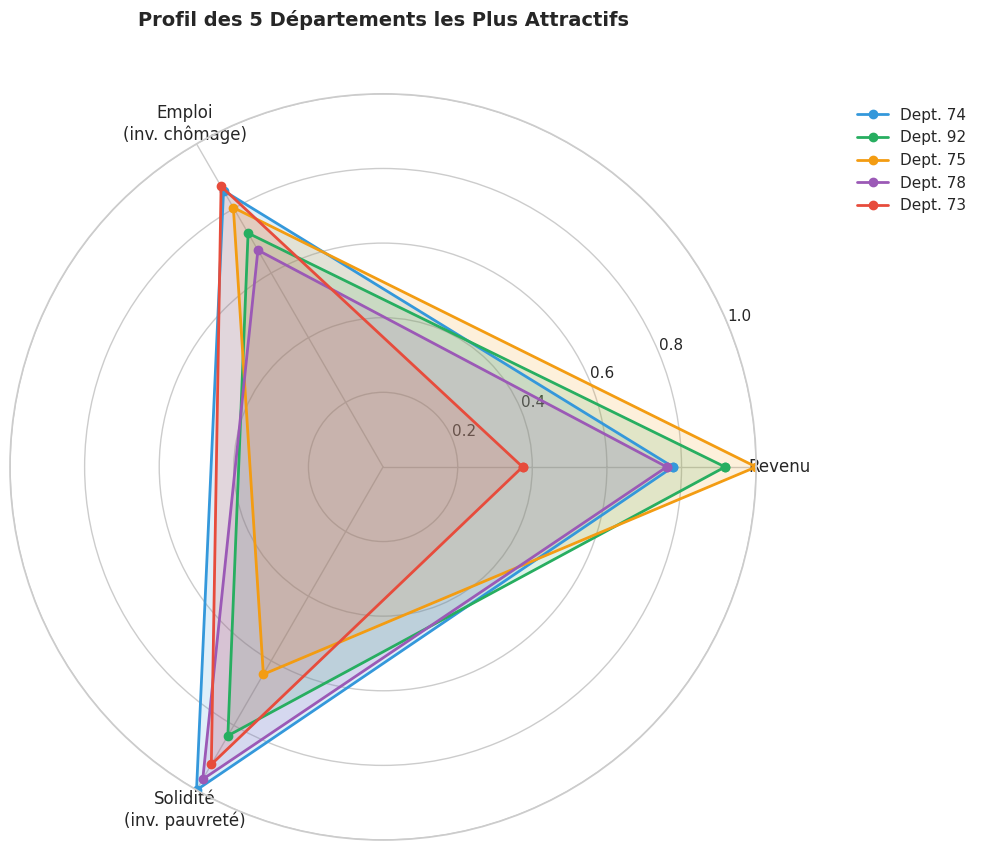

In [19]:
# Visualisation finale : Radar chart des meilleurs départements
from math import pi

# Sélection des 5 meilleurs et normalisation
top5 = df_opportunite.nlargest(5, 'score_attractivite').copy()

# Préparation des données pour le radar
categories = ['Revenu', 'Emploi\n(inv. chômage)', 'Solidité\n(inv. pauvreté)']
N = len(categories)

# Normalisation 0-1 (inverser chômage et pauvreté car plus bas = mieux)
top5['rev_score'] = (top5['revenu_median'] - df_opportunite['revenu_median'].min()) / \
                    (df_opportunite['revenu_median'].max() - df_opportunite['revenu_median'].min())
top5['emp_score'] = 1 - (top5['taux_chomage'] - df_opportunite['taux_chomage'].min()) / \
                    (df_opportunite['taux_chomage'].max() - df_opportunite['taux_chomage'].min())
top5['sol_score'] = 1 - (top5['taux_pauvrete'] - df_opportunite['taux_pauvrete'].min()) / \
                    (df_opportunite['taux_pauvrete'].max() - df_opportunite['taux_pauvrete'].min())

# Angles
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]  # Fermer le cercle

# Plot
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))

colors_radar = [COLORS['accent'], COLORS['success'], COLORS['warning'], 
                COLORS['info'], COLORS['secondary']]

for idx, (_, row) in enumerate(top5.iterrows()):
    values = [row['rev_score'], row['emp_score'], row['sol_score']]
    values += values[:1]
    
    ax.plot(angles, values, 'o-', linewidth=2, label=f"Dept. {row['code_dept']}", 
            color=colors_radar[idx])
    ax.fill(angles, values, alpha=0.15, color=colors_radar[idx])

ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, size=12)
ax.set_ylim(0, 1)

plt.title('Profil des 5 Départements les Plus Attractifs', size=14, fontweight='bold', y=1.08)
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))

plt.tight_layout()
plt.show()

---

## 10. Conclusions et Recommandations

### Synthèse des Analyses

#### Indicateurs Macroéconomiques
- **Inflation** : retour à la normale (~1%) après le pic de 2023 (6.3%)
- **Prix immobiliers** : hausse continue (+130% depuis 2000), supérieure à l'inflation
- **Construction** : volumes variables, sensibles aux cycles économiques

#### Disparités Territoriales
- **Écart de chômage** : ratio 1:5 entre les départements les plus et moins dynamiques
- **Revenus** : forte hétérogénéité, IDF en tête
- **Corrélations fortes** : revenu ↔ chômage ↔ pauvreté

#### Départements Attractifs (pour l'immobilier)
- Hauts-de-Seine (92), Yvelines (78), Haute-Savoie (74)
- Caractéristiques : revenus élevés, chômage bas, dynamisme économique

#### Départements à Risque
- DOM-TOM, Nord, certains départements du Sud
- Caractéristiques : chômage élevé, pauvreté importante

### Recommandations pour le Projet

1. **Pondérer les prix immobiliers** par le revenu local pour évaluer l'accessibilité
2. **Intégrer le taux de chômage** comme indicateur de risque
3. **Suivre le dynamisme entrepreneurial** comme proxy de l'attractivité future
4. **Considérer l'inflation réelle** pour les projections de prix

---

*Analyse réalisée dans le cadre du projet Compagnon Immobilier - DataScientest*